This is a reformatted and lightly revised version of a [blog post from 2019](http://rdkit.blogspot.com/2019/01/more-on-constrained-embedding.html).

Quite a while ago I did a [blog post](http://rdkit.blogspot.com/2013/12/using-allchemconstrainedembed.html) showing how to use the Python function `AllChem.ConstrainedEmbed()` to generate conformers where the positions of a set of atoms are constrained to match the coordinates of a template molecule. More recently [a question](https://www.mail-archive.com/rdkit-discuss@lists.sourceforge.net/msg08465.html) came up on the mailing list about how to use the core embedding functionality that lies underneath `AllChem.ConstrainedEmbed()`; this short post will look at that.

In [1]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import rdDepictor
rdDepictor.SetPreferCoordGen(True)
IPythonConsole.molSize = (350,350)
from rdkit.Chem import AllChem
import math
import rdkit
print(rdkit.__version__)

2022.09.4


We're going to work with cyclosporine here, since it's delightfully complicated, which makes it fun. :-) In this case we're going to ignore atomic stereochemistry in order to speed the conformer generation up (the RDKit tends to take a while to generate conformers for molecules with a large number of stereocenters). 

We'll also define the macrocylce as the core; this is what we're going to use to provide constraints.

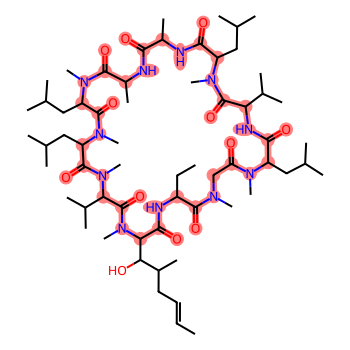

In [2]:
m = Chem.MolFromSmiles('C/C=C/CC(C)C(O)C1C(=O)NC(CC)C(=O)N(C)CC(=O)N(C)C(CC(C)C)C(=O)NC(C(C)C)C(=O)N(C)C(CC(C)C)C(=O)NC(C)C(=O)NC(C)C(=O)N(C)C(CC(C)C)C(=O)N(C)C(CC(C)C)C(=O)N(C)C(C(C)C)C(=O)N1C')
rdDepictor.Compute2DCoords(m)

core = Chem.MolFromSmiles('C1C(=O)NCC(=O)NCC(=O)NCC(=O)NCC(=O)NCC(=O)NCC(=O)NCC(=O)NCC(=O)NCC(=O)NCC(=O)N1')
m.GetSubstructMatch(core)
m

Start by generating a conformer for cyclosporine itself.

In [3]:
mh = Chem.AddHs(m)
AllChem.EmbedMolecule(mh,randomSeed=0xf00d)

0

For the other molecule, we'll take a molecule I pulled from ChEMBL that includes the core.
I also removed stereochemistry here.

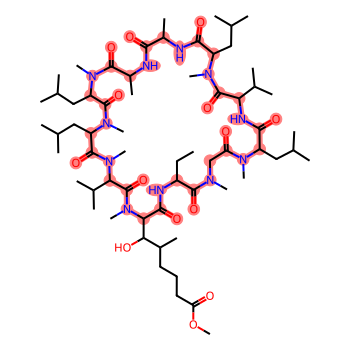

In [4]:
smi = 'CCC1NC(=O)C(C(O)C(C)CCCC(=O)OC)N(C)C(=O)C(C(C)C)N(C)C(=O)C(CC(C)C)N(C)C(=O)C(CC(C)C)N(C)C(=O)C(C)NC(=O)C(C)NC(=O)C(CC(C)C)N(C)C(=O)C(C(C)C)NC(=O)C(CC(C)C)N(C)C(=O)CN(C)C1=O'
newm = Chem.MolFromSmiles(smi)
rdDepictor.Compute2DCoords(newm)
newm.GetSubstructMatch(core)
newm

Generate an unconstrained conformer for that:

In [5]:
newmh = Chem.AddHs(newm)
AllChem.EmbedMolecule(newmh,randomSeed=0xf00d)

0

Now calculate the RMSD between the core atoms in cylosporine and in our test molecule.

In [6]:
m_match = mh.GetSubstructMatch(core)
newm_match = newmh.GetSubstructMatch(core)
delta2 = 0.0
for mi,newmi in zip(m_match,newm_match):
    d = (mh.GetConformer().GetAtomPosition(mi) - newmh.GetConformer().GetAtomPosition(newmi)).LengthSq()
    delta2 += d
print('core RMSD:',math.sqrt(delta2/len(m_match)))

core RMSD: 7.101400868778492


There's no reason to expect this RMSD to be anything other than huge: we're using different conformer of a flexible core and haven't aligned them to each other.

We can go ahead and do an alignmeent and see how that affects the RMSD:

In [7]:
AllChem.AlignMol(newmh,mh,atomMap = list(zip(newm_match,m_match)))
delta2 = 0.0
for mi,newmi in zip(m_match,newm_match):
    d = (mh.GetConformer().GetAtomPosition(mi) - newmh.GetConformer().GetAtomPosition(newmi)).LengthSq()
    delta2 += d
print('aligned core RMSD:',math.sqrt(delta2/len(m_match)))

aligned core RMSD: 2.067717832557964


Again, it's not surprising that this is a large RMSD: the core is quite flexible and we haven't constrained it at all.

Adding constraints is the point of this blog post though, so let's move onto that.

`AllChem.EmbedMolecule()` can be given constraints for the positions of certain atoms using the `coordMap` argument, which expects a dictionary that provides a `Point3D` for each atom that should have a fixed position.

In [8]:
cmap = {newm_match[i]:mh.GetConformer().GetAtomPosition(m_match[i]) for i in range(len(m_match))}
AllChem.EmbedMolecule(newmh,randomSeed=0xf00d,coordMap=cmap)
delta2 = 0.0
for mi,newmi in zip(m_match,newm_match):
    d = (mh.GetConformer().GetAtomPosition(mi) - newmh.GetConformer().GetAtomPosition(newmi)).LengthSq()
    delta2 += d
print('core RMSD:',math.sqrt(delta2/len(m_match)))

core RMSD: 2.5231352176127078


Wait... what happened here? Shouldn't this number be smaller since we introduced constraints? This was the question on the mailing list.

The function `AllChem.EmbedMolecule()` uses the coordinates provided in `coordMap` to set elements of the distance bounds matrix that is used to generate conformers (details about the RDKit's distance-geometry-based conformer generator are in the [documentation](https://www.rdkit.org/docs/GettingStartedInPython.html#working-with-3d-molecules)). This results in conformers where the distances between the atoms in the conformer closely match the corresponding distances in the `coordMap`.

Note that, because the coordinates are being constrained using the distances between them, you should expect rigid shifts of the core atoms relative to the constraints. This is solveable by aligning the core of the test molecule to the core of the reference:

In [9]:
AllChem.AlignMol(newmh,mh,atomMap = list(zip(newm_match,m_match)))
delta2 = 0.0
for mi,newmi in zip(m_match,newm_match):
    d = (mh.GetConformer().GetAtomPosition(mi) - newmh.GetConformer().GetAtomPosition(newmi)).LengthSq()
    delta2 += d
print('aligned core RMSD:',math.sqrt(delta2/len(m_match)))

aligned core RMSD: 0.9007025663628238


Note that the output coordinates don't match the constraint coordinates exactly. This will almost always be the case; they should be close, but some differences are, unforunately, expected due to the nature of the algorithm.

An alternative is to use random coordinate embedding instead of the usual distance-bounds embedding to generate the initial coordinates in the conformer generation. When we do this it's possible to get exact coordinate matches of the core and no alignment is necessary. Random-coordinate embedding is not the default because the current RDKit implementation tends to be slower than the other approach.

In [10]:
AllChem.EmbedMolecule(newmh,randomSeed=0xf00d,coordMap=cmap,useRandomCoords=True)
delta2 = 0.0
for mi,newmi in zip(m_match,newm_match):
    d = (mh.GetConformer().GetAtomPosition(mi) - newmh.GetConformer().GetAtomPosition(newmi)).LengthSq()
    delta2 += d
print('core RMSD:',math.sqrt(delta2/len(m_match)))

core RMSD: 0.0


It's worth taking a look at the conformers of our molecules. We'll do that using [py3Dmol](https://github.com/3dmol).
This code snippet uses a bit of convenience functionality that the RDKit's IPythonConsole provides, but it also demonstrates how to draw molecules with different colors.

In [11]:
import py3Dmol
def drawit(ms, p=None, confId=-1, removeHs=True,colors=('cyanCarbon','redCarbon','blueCarbon')):
        if p is None:
            p = py3Dmol.view(width=400, height=400)
        p.removeAllModels()
        for i,m in enumerate(ms):
            if removeHs:
                m = Chem.RemoveHs(m)
            IPythonConsole.addMolToView(m,p,confId=confId)
            p.setStyle({'model':-1,},
                            {'stick':{'colorscheme':colors[i%len(colors)]}})
        p.zoomTo()
        return p.show()

In [12]:
drawit((mh,newmh))

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Here one molecule is drawn with cyan bonds and the other with red bonds.

## Extra: minimize with constraints

In [30]:
from rdkit.Chem import rdForceFieldHelpers
mcp = Chem.Mol(newmh)
mmffps = rdForceFieldHelpers.MMFFGetMoleculeProperties(mcp)
ff = rdForceFieldHelpers.MMFFGetMoleculeForceField(mcp,mmffps)
maxIters = 10
while ff.Minimize(maxIts=1000) and maxIters>0:
    maxIters -= 1

In [31]:
delta2 = 0.0
for mi,newmi in zip(m_match,newm_match):
    d = (mh.GetConformer().GetAtomPosition(mi) - mcp.GetConformer().GetAtomPosition(newmi)).LengthSq()
    delta2 += d
print('core RMSD:',math.sqrt(delta2/len(m_match)))

core RMSD: 2.313775204899967


In [32]:
drawit((mh,mcp))

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

That's messed up the core coordinates... we can fix that by adding some position constraints to the force field:

In [33]:
mcp = Chem.Mol(newmh)
mmffps = rdForceFieldHelpers.MMFFGetMoleculeProperties(mcp)
ff = rdForceFieldHelpers.MMFFGetMoleculeForceField(mcp,mmffps)
for atidx in newm_match:
    ff.MMFFAddPositionConstraint(atidx,0.05,200)
maxIters = 10
while ff.Minimize(maxIts=1000) and maxIters>0:
    maxIters -= 1

In [34]:
delta2 = 0.0
for mi,newmi in zip(m_match,newm_match):
    d = (mh.GetConformer().GetAtomPosition(mi) - mcp.GetConformer().GetAtomPosition(newmi)).LengthSq()
    delta2 += d
print('core RMSD:',math.sqrt(delta2/len(m_match)))

core RMSD: 0.12659186987312163


Much better!

In [35]:
drawit((mh,mcp))

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol